# Carbon System Example Code

**Author: Andrew Reed**

### Purpose
The purpose of this notebook is to provide an example of working with ```PCO2A``` data from the Ocean Observatories Initiative. Example datasets are provided in the ```data``` directory. This code is meant to highlight necessary post-download processing steps to improve data quality and useability.

### Data
This notebook makes use of the PCO2A dataset from the Coastal Pioneer Inshore Surface Mooring (CP03ISSM). This instrument is located at a latitude, longitude of 40.35945, -70.88498 on the New England Shelf break.

The example ```PCO2A``` datasets were downloaded as netCDF files from the Ocean Observatories Initiative data portal for all available, reformatted to clean up the dimensions, and then merged into one dataset. This process is outlined in the notebook **OOI - Data Downloading and Cleaning**. 

The discrete bottle data were downloaded from the OOI Alfresco Document Server at https://alfresco.oceanobservatories.org. The relevant files are in OOI > Global Irminger Sea Array > Cruise Data > "Cruise Directory" > Ship Data > Water Sampling > "Discrete Summary Sample Sheet.xlsx". For more information and an example of working with and validating discrete sample data please follow the **OOI - Discrete Bottle Data** example notebook. 

### Dependencies & Use
This notebook and related examples are all done using the Python programming language. Additionally, it relies on several github repositories and existing code bases for working with OOI data. The first is the OOINet repository at https://github.com/reedan88/OOINet. This repo hosts modules and tools that are designed to assist in requesting, importing, and downloading data from the Ocean Observatories Initiative API by M2M requests. It also utilizes code from the OOI Data Explorations repo at https://github.com/oceanobservatories/ooi-data-explorations. This repository contains modules, tools, and notebooks that also assist with downloading data from the OOI API, as well as extensive tools for processing the downloaded datasets to make them more user-friendly. Lastly, functions written specifically for this example notebook are stored in the utils.py module in the parent directory, allowing for direct imports.

In [1]:
# Import libraries
import os, sys, re
import yaml
import numpy as np
import pandas as pd
import xarray as xr
# Supress auto warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the OOINet M2M tool
sys.path.append("/home/areed/Documents/OOI/reedan88/ooinet/ooinet/")
from m2m import M2M

In [3]:
# Add plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sys.path.append("..")
from utils import *

#### Set OOINet API access
In order access and download data from OOINet, need to have an OOINet api username and access token. Those can be found on your profile after logging in to OOINet. Your username and access token should NOT be stored in this notebook/python script (for security). It should be stored in a yaml file, kept in the same directory, named user_info.yaml.

In [5]:
userinfo = yaml.load(open("../user_info.yaml"), Loader=yaml.SafeLoader)
username = userinfo["apiname"]
token = userinfo["apikey"]

#### Connect to OOINet

In [6]:
OOINet = M2M(username, token)

---
## Load the data

First, we want to load the data into the notebook. Below, I utilize ```xarray``` to open and work with the dataset. ```xarray``` is optimized for working with multidimensional data and is especially useful for datasets which may be bigger than available memory on the computer.

In [8]:
# Load the phsen dataset from the local directory, using "chunks" to keep the data in optimized dask arrays
pco2a = xr.open_dataset("../data/CP03ISSM-SBD12-04-PCO2AA000_combined.nc")#, chunks="auto")

# For convience, also set the reference designator name
refdes = "CP03ISSM-SBD12-04-PCO2AA000"

Look at the structure of the ```PHSEN``` dataset:

In [9]:
pco2a

<xarray.Dataset>
Dimensions:                                   (time: 113066)
Coordinates:
  * time                                      (time) datetime64[ns] 2016-10-1...
Data variables: (12/35)
    air_temperature                           (time) float64 ...
    avg_irga_temperature                      (time) float32 ...
    barometric_pressure                       (time) float64 ...
    current_a2d                               (time) float64 ...
    date_time_string                          (time) |S5 ...
    dcl_controller_timestamp                  (time) |S5 ...
    ...                                        ...
    precipitation                             (time) float64 ...
    relative_humidity                         (time) float64 ...
    sea_surface_temperature                   (time) float64 ...
    shortwave_irradiance                      (time) float64 ...
    supply_voltage                            (time) float32 ...
    zero_a2d                                  (time) float64 ...
Attributes: (12/70)
    node:                               SBD12
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             pco2a_a_dcl_instrument_water
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.35945
    lon:                                -70.88498
    Location_name:                      Coastal Pioneer Inshore Surface Moori...

The principle data variable we are interested in is the ```partial_pressure_co2_ssw``` variable. Other data variables we will be using are the ```deployment``` variable, which contains an entry for which deployment each timestamp corresponds to.

Now, plot the ```partial_pressure_co2_ssw``` data variable along with the relevant deployments to get an idea of when the instrument was changed.

Text(0, 0.5, 'pCO2 Surface Seawater')

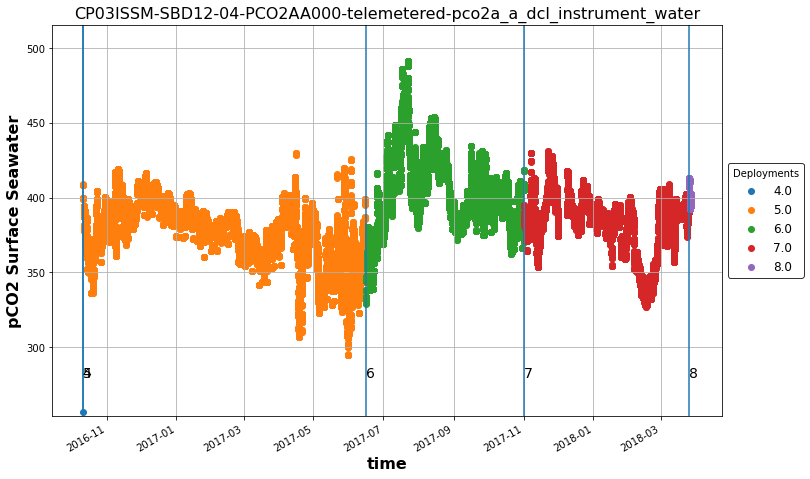

In [11]:
fig, ax = plot_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

We see from this figure that the time series spans three deployments of a ```PCO2A``` instrument at CP03ISSM-SBD12-04-PCO2A000. We can also see that there are differences in variability both within deployments, such as deployment 1, and between deployments, such as the contrasting variability of deployment 4 vs. deployment 5.

The next step is to take a look at the annotations and see what they indicate about the data.

---
## Annotations

Since we are loading annotations which were previously downloaded and saved as a csv, we first need to do some parsing of the annotations to properly work with lists, etc. in the pandas dataframe.

In [24]:
annotations = load_annotations(f"../data/{refdes}_annotations.csv")
annotations

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,1508,CP03ISSM,SBD12,None,telemetered,None,1529301419000,1540583520000,Data telemetry disabled due to chronic issues ...,False,leila@marine.rutgers.edu,0,[]
1,.AnnotationRecord,1824,CP03ISSM,SBD12,04-PCO2AA000,None,None,1529280000000,1536537600000,Deployment 8: Instrument was disabled 2018-06-...,False,cdobson@whoi.edu,9,[]
2,.AnnotationRecord,1813,CP03ISSM,SBD12,04-PCO2AA000,None,None,1572825600000,1573732800000,Deployment 11: *UPDATED 2019-11-14: Instrument...,False,cdobson@whoi.edu,0,[]
3,.AnnotationRecord,2048,CP03ISSM,SBD12,04-PCO2AA000,None,None,1585691940000,1604236560000,Deployment 11: The PCO2A instrument failed (po...,False,swhite@whoi.edu,9,[]
4,.AnnotationRecord,1889,CP03ISSM,None,None,None,None,1578441600000,1604236560000,Deployment 11: UPDATED 2020-04-27: As of 2020-...,False,cdobson@whoi.edu,9,[]
5,.AnnotationRecord,1715,CP03ISSM,SBD12,04-PCO2AA000,None,None,1554648120000,1569505800000,UPDATED 2020-08-31: The vendor attempted to co...,False,swhite@whoi.edu,3,[]
6,.AnnotationRecord,3182,CP03ISSM,SBD12,None,None,None,1629640800000,1636659000000,Deployment 13: DCL12 power was disabled on 8/2...,False,cdobson@whoi.edu,9,[]
7,.AnnotationRecord,2902,CP03ISSM,SBD12,04-PCO2AA000,None,None,1622739600000,1636659000000,Deployment 13: Instrument values are suspect b...,False,cdobson@whoi.edu,3,[]
8,.AnnotationRecord,3372,CP03ISSM,SBD12,04-PCO2AA000,None,None,1629640800000,1636113600000,Deployment 13: The instrument was powered off ...,False,cdobson@whoi.edu,9,[]


Now we can look at a specific annotation. Lets see what the **```id```** 1427 says:

In [25]:
# Filter the annotations to be applicable to the given dataset
beginDT = pco2a.time.min().values
endDT = pco2a.time.max().values
beginDT = OOINet._unix_epoch_time(beginDT)
endDT = OOINet._unix_epoch_time(endDT)
annotations[(annotations["beginDT"] >= beginDT) & (annotations["endDT"] <= endDT)]

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters


Looks like there are no annotations applicable to the data for this time period. Yay!

Now, we can add the "qc_flag" from the annotations to our dataset:

In [26]:
# Add in the annotation qc flags
pco2a = OOINet.add_annotation_qc_flag(pco2a, annotations)

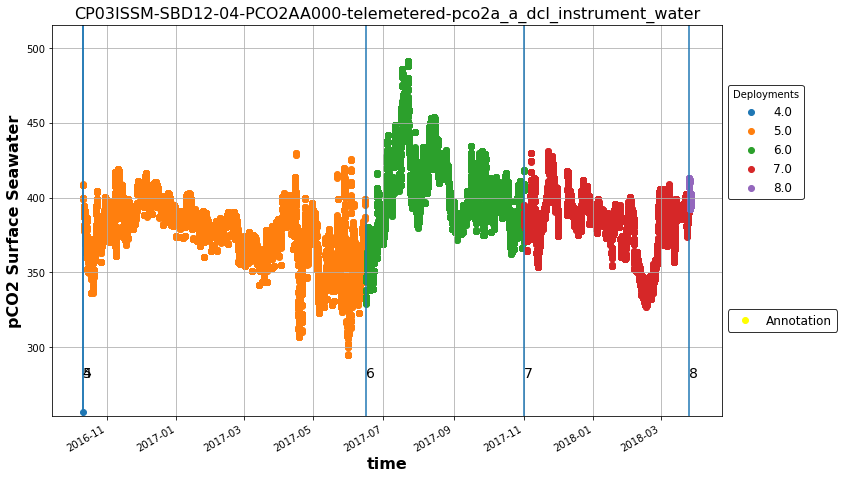

In [28]:
# Plot figure which highlights data points with a corresponding annotation
fig, ax = plot_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s, = ax.plot(pco2a.time.where(pco2a.rollup_annotations_qc_results == 9), 
             pco2a.partial_pressure_co2_ssw.where(pco2a.rollup_annotations_qc_results == 9), 
             marker="o", linestyle="", color="yellow", label="Annotation")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


We can visually check that there are no annotations for the time period that we are interested in here! Let's zoom in on a much smaller portion of time:

Text(0, 0.5, 'pCO2 Surface Seawater')

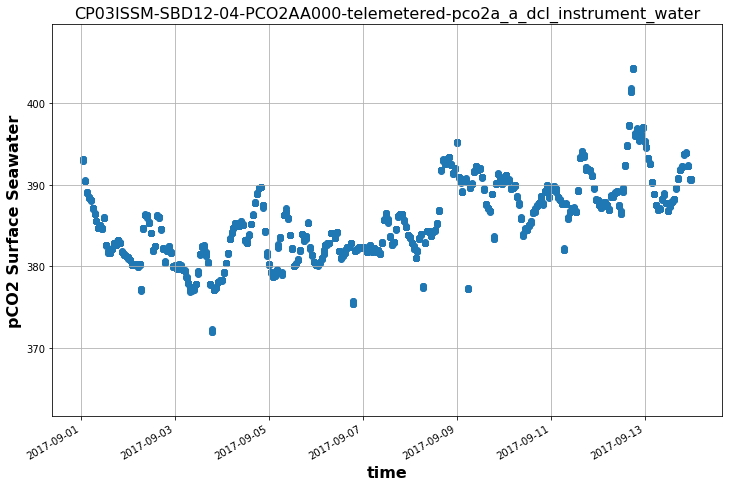

In [37]:
subset_data = pco2a.sel(time=slice("2017-09-01","2017-09-13"))

fig, ax = plot_variable(subset_data, "partial_pressure_co2_ssw", add_deployments=False)
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")


In the above figure, we can see that there is a regular issue with low measurements. This is the "autozeroing" error with the Pro-Ocean instruments, where every 12 hours the instrument auto-zeros. However, the scheduled next measurment captures part of the rezeroing, resulting in an artifically low value.

Text(0, 0.5, 'pCO2 Surface Seawater')

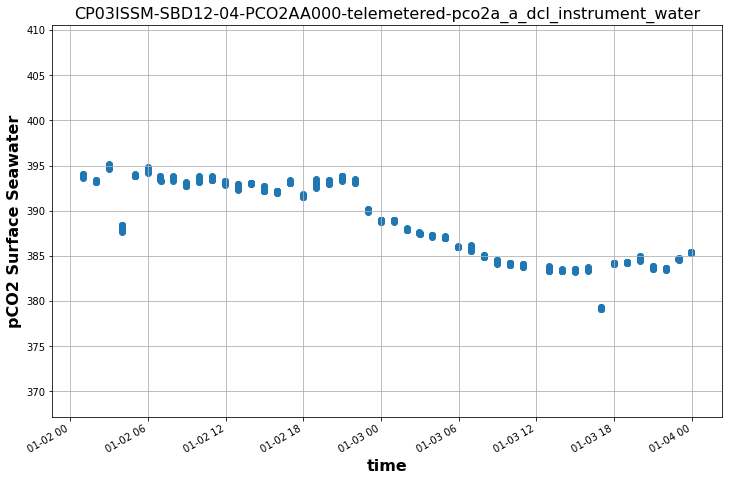

In [42]:
subset_data = pco2a.sel(time=slice("2018-01-02","2018-01-03"))

fig, ax = plot_variable(subset_data, "partial_pressure_co2_ssw", add_deployments=False)
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")


In [53]:
# Find the autozero errors
I5 = ((pco2a["time.hour"] == 9) | (pco2a["time.hour"] == 21)) & (pco2a.deployment == 5)
I6 = ((pco2a["time.hour"] == 6) | (pco2a["time.hour"] == 18)) & (pco2a.deployment == 6)
I7 = ((pco2a["time.hour"] == 7) | (pco2a["time.hour"] == 19)) & (pco2a.deployment == 7)

# Add a flag with the autozero erros
pco2a["partial_pressure_co2_ssw_autozero_flag"] = pco2a.partial_pressure_co2_ssw.astype(int)*0 + 1
pco2a["partial_pressure_co2_ssw_autozero_flag"][I5] = 4
pco2a["partial_pressure_co2_ssw_autozero_flag"][I6] = 4
pco2a["partial_pressure_co2_ssw_autozero_flag"][I7] = 4

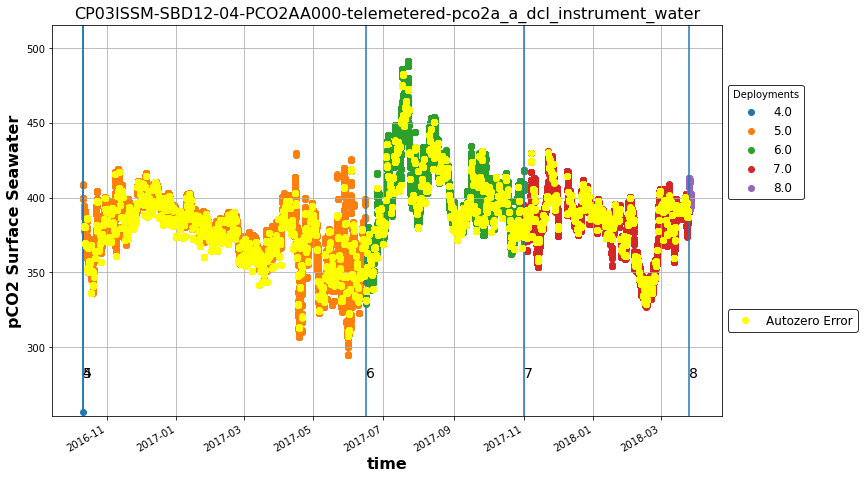

In [55]:
# Plot the data with the autozero errors flagged
fig, ax = plot_variable(pco2a, "partial_pressure_co2_ssw")
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s, = ax.plot(pco2a.time.where(pco2a.partial_pressure_co2_ssw_autozero_flag == 4), 
             pco2a.partial_pressure_co2_ssw.where(pco2a.partial_pressure_co2_ssw_autozero_flag == 4), 
             marker="o", linestyle="", color="yellow", label="Autozero Error")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)

With the autozero error identified, we can drop those values from the dataset!

In [95]:
pco2a_good = pco2a.where(pco2a.partial_pressure_co2_ssw_autozero_flag == 1, drop=True)

---
## Bottle Data

The next step is to start comparing the PHSEN-measured seawater pH against the pH measured via Niskin collection and lab analysis. We start by loading all of the availabe Global Irminger Sea Array > Discrete Sample Summary sheets into a pandas dataframe. 

Once the bottle data is loaded, we need to do some processing to make the data easier to work with in python with pandas. The processing steps we'll take include:
1. Replacing fill values with NaNs
2. Parsing and converting timestamps
3. Replacing odd/unexpected values
4. Interpreting the quality flags to correspond to QARTOD QC standards
5. Filtering out bad data

In [56]:
from bottle_utils import *

In [57]:
bottle_dir = "../data/bottle_data/"
bottle_data = pd.DataFrame()
for file in os.listdir(bottle_dir):
    bottle_data = bottle_data.append(pd.read_excel(bottle_dir + file), ignore_index=True)

Replace the fill value of ```-9999999``` with NaNs:

In [58]:
bottle_data = bottle_data.replace(to_replace="-9999999", value=np.nan)
bottle_data = bottle_data.replace(to_replace=-9999999, value=np.nan)

Convert times from strings to pandas datetime objects and remove the timezone:

In [59]:
bottle_data["Start Time [UTC]"] = bottle_data["Start Time [UTC]"].apply(lambda x: convert_times(x))
bottle_data["CTD Bottle Closure Time [UTC]"] = bottle_data["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

Convert any values with a "<", which indicates a value not statistically significant from zero, with zero:

In [60]:
bottle_data = bottle_data.applymap(not_statistically_sigificant)

#### Filter data
Next, we want to filter the data based on the data flag associated with the sample. First, we should drop all of the ```NaN``` values in the Niskin column to eliminate entries without any bottle samples. While these CTD casts may be of interest, the bottle data does not have the relevant data.

In [61]:
# Deployment
for col in bottle_data.columns:
    if "Flag" in col:
        if "CTD" in col and "File" not in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_ctd_flag(x))
        elif "Discrete" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_discrete_flag(x))
        elif "Replicate" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_replicate_flag(x))
        elif "Niskin" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_niskin_flag(x))
        else:
            pass

In [62]:
bottle_data.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated DIC [umol/kg],Calculated pCO2 [uatm],Calculated pH,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,Unnamed: 80,Unnamed: 81
0,AR24A,1,LTER - 1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
1,AR24A,2,LTER - 2,40.9645,-70.830500,2017-10-22 21:14:41+00:00,002,*0000000000000100,NaN,AR24002.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
2,AR24A,3,LTER - 3,40.7985,-70.831167,2017-10-22 22:38:07+00:00,003,*0000000000000100,NaN,AR24003.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
3,AR24A,3,LTER - 3,40.7985,-70.831167,2017-10-22 22:38:07+00:00,003,*0000000000000100,NaN,AR24003.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
4,AR24A,3,LTER - 3,40.7985,-70.831167,2017-10-22 22:38:07+00:00,003,*0000000000000100,NaN,AR24003.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN


---
### Calculate Carbon System Parameters
---
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. I calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

In [63]:
# Calculate the Carbon System Parameters
from PyCO2SYS import CO2SYS

---
### Calculate Physical Properties
With the bottle samples cleaned up, we next want to calculate the conservative seawater properties, such as density, conservative temperature, absolute salinity, etc., using the updated TEOS properties with the ```gsw``` package.

In [64]:
import gsw

In [65]:
# ======================================================================
# Deployment: Calculate some key physical parameters to get density based on TEOS-10
SP = bottle_data[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].mean(axis=1)
T = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
P = bottle_data["CTD Pressure [db]"]
LAT = bottle_data["CTD Latitude [deg]"]
LON = bottle_data["CTD Longitude [deg]"]

# Absolute salinity
SA = gsw.conversions.SA_from_SP(SP, P, LON, LAT)
bottle_data["CTD Absolute Salinity [g/kg]"] = SA

# Conservative temperature
CT = gsw.conversions.CT_from_t(SA, T, P)
bottle_data["CTD Conservative Temperature"] = CT

# Density
RHO = gsw.density.rho(SA, CT, P)
bottle_data["CTD Density [kg/m^3]"] = RHO

# Calculate potential density
SIGMA0 = gsw.density.sigma0(SA, CT)
bottle_data["CTD Sigma [kg/m^3]"] = RHO

del SP, T, P, LAT, LON, SA, CT, RHO, SIGMA0

---
### Calculate Carbon System Parameters
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. We can calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

Use of ```CO2SYS``` requires, at a minimum, the following inputs:
* ```PAR1```: First measured carbon system measurement
* ```PAR2```: Second measured carbon system measurement
* ```PAR1_type```: The type of PAR1 
        * 1 = Total Alkalinity umol/kg
        * 2 = DIC umol/kg
        * 3 = pH Total Scale
        * 4 = pCO2
        * 5 = fCO2
* ```PAR2_type```: The type of PAR2

The following are optional hydrographic inputs:
* ```salinity```: practical salinity
* ```temperature```: the temperature at which PAR1 and PAR2 are provided (in C)
* ```pressure```: the water pressure at which ```PAR1``` and ```PAR2``` are measured

The ```CO2SYS``` program calculations use carbonic acid dissociation coefficients K1 and K2 from Leuker et al. (2000), sulfate dissociation constant KSO4 from Dickson (1990), total borate concentration from Lee et al. (2010), and HF dissociation coefficient KHF from Perez and Fraga (1987) were used in carbonate system calculations. Input temperatureand pressure is set to the temperature and pressure that pH samples were processed at (25 degrees celcius, 0 dbar) and output temperature and pressure was set to in-situ conditions.

In [66]:
PAR1 = bottle_data['Discrete Alkalinity [umol/kg]']
PAR2 = bottle_data['Discrete DIC [umol/kg]']
PAR1TYPE = 1
PAR2TYPE = 2
SAL = bottle_data['Discrete Salinity [psu]']
TEMPIN = 25
TEMPOUT = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
PRESIN = 0
PRESOUT = bottle_data['CTD Pressure [db]']
SI = bottle_data['Discrete Silicate [uM]'].fillna(value=0)
PO4 = bottle_data['Discrete Phosphate [uM]'].fillna(value=0)
PHSCALEIN = 1
K1K2CONSTANTS = 1
K2SO4CONSTANTS = 1

With the relevant parameters declared, pass the values into ```CO2SYS``` and get out the calculated values:

In [67]:
CO2dict = CO2SYS(PAR1, PAR2, PAR1TYPE, PAR2TYPE, SAL, TEMPIN, TEMPOUT, PRESIN, PRESOUT, SI, PO4, PHSCALEIN, K1K2CONSTANTS, K2SO4CONSTANTS)

Now add the calculated carbon system parameters to the cruise info:

In [68]:
bottle_data['Calculated Alkalinity [umol/kg]'] = CO2dict['TAlk']
bottle_data['Calculated CO2aq [umol/kg]'] = CO2dict['CO2out']
bottle_data['Calculated CO3 [umol/kg]'] = CO2dict['CO3out']
bottle_data['Calculated DIC [umol/kg]'] = CO2dict['TCO2']
bottle_data['Calculated pCO2 [uatm]'] = CO2dict['pCO2out']
bottle_data['Calculated pCO2in'] = CO2dict['pCO2in']
bottle_data['Calculated pH'] = CO2dict['pHoutTOTAL']

Compare the **Discrete pH** against the **Calculated pH** derived from the DIC and TA using ```CO2SYS```:

In [69]:
bottle_data[["Discrete pH [Total scale]","Calculated pH"]].dropna()

,Discrete pH [Total scale],Calculated pH
67,7.6683,7.893431
76,7.9928,8.033540
101,7.7822,7.923498
108,8.0034,8.026776
122,7.7856,7.928578
...,...,...
3168,7.7133,8.090181
3175,7.7110,8.032895
3179,7.8437,8.116096
3180,7.8438,8.103356


Notice that the **Discrete pH** is lower than the **Calculated pH**. Why is that? Well, the **Discrete pH** was measured in the lab at warmer temperatures and surface pressure. We'll want to use the **Calculated pH** to compare with the PHSEN data.

However, we have measured pH! So we don't want to use the pH calculated from DIC and TA. Instead, we can plug the measured pH into ```CO2SYS``` to get the pH at in-situ conditions to match the observations from the PHSEN.

In [70]:
PAR1 = bottle_data['Discrete pH [Total scale]']
PAR2 = bottle_data['Discrete DIC [umol/kg]']
PAR1TYPE = 3
PAR2TYPE = 2

Recalculate the ```CO2SYS``` to get the in-situ pH:

In [71]:
CO2dict = CO2SYS(PAR1, PAR2, PAR1TYPE, PAR2TYPE, SAL, TEMPIN, TEMPOUT, PRESIN, PRESOUT, SI, PO4, PHSCALEIN, K1K2CONSTANTS, K2SO4CONSTANTS)

# Add the recalculated pH to the bottle data
bottle_data['Calculated pH'] = CO2dict['pHoutTOTAL']

Compare the **Discrete pH** against the **Calculated pH** which is the **Discrete pH** adjusted for pressure and temperature using ```CO2SYS```:

In [72]:
bottle_data[["Discrete pH [Total scale]","Calculated pH"]].dropna()

,Discrete pH [Total scale],Calculated pH
67,7.6683,7.934179
76,7.9928,8.073602
101,7.7822,7.951035
108,8.0034,8.076070
122,7.7856,7.937108
...,...,...
3168,7.7133,8.032495
3175,7.7110,8.031469
3179,7.8437,8.108139
3180,7.8438,8.108355


#### Compare Bottle and PHSEN Data

With the Discrete Bottle pH now adjusted for temperature and pressure to match in-situ conditions, we can begin to compare the Bottle pH with the PHSEN-measured pH. First, we need to identify which bottle measurements occurred where the PHSEN instrument is located.

Helpfully, the PHSEN datasets returned from OOI contain the latitude and longitude of the buoy where it was deployed. Additionally, we can get the **```Deployment```** information for the PHSEN reference designator, which includes the deployed depth. Using those two pieces of info, we can search the bottle data for measurements which occured within some set distance and depth of the PHSEN. 

For the Global Irminger Sea Array, a fairly relaxed maximum distance can be used, due to larger horizontal scales of variability. In comparison, observations at the Coastal Arrays - Pioneer and Endurace - should utilize smaller maximum distances.

In order to get the deployed depths, we need to query the deployment information from OOINet:

In [73]:
deployments = OOINet.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,15,CGINS-PCO2AA-35260,1767,40.367167,-70.881817,0.0,2022-04-11 21:51:00,None,AR66,None
0,14,CGINS-PCO2AA-33182,2431,40.3646,-70.888252,0.0,2021-11-01 14:10:00,2022-04-13 21:24:00,AR61,AR66
0,13,CGINS-PCO2AA-34231,3713,40.3671,-70.881567,0.0,2021-04-02 20:47:00,2021-11-11 19:30:00,AR52,AR61
0,12,CGINS-PCO2AA-33182,2431,40.367077,-70.881735,0.0,2020-10-31 19:31:00,2021-03-31 19:02:00,AR48,AR52
0,11,CGINS-PCO2AA-31124,3492,40.3594,-70.8851,0.0,2019-09-26 13:50:00,2020-11-01 13:16:00,AR39,AR48
0,10,CGINS-PCO2AA-33154,2305,40.36723,-70.88147,0.0,2019-04-07 14:42:00,2019-10-01 11:58:00,AR34,AR39
0,9,CGINS-PCO2AA-31124,3492,40.36728,-70.88105,0.0,2018-10-29 03:43:00,2019-04-06 18:51:00,AR31,AR34
0,8,CGINS-PCO2AA-33154,2305,40.36718,-70.88215,0.0,2018-03-25 15:27:00,2018-10-26 19:52:00,AR28,AR31
0,7,CGINS-PCO2AA-34222,3556,40.358983,-70.885467,0.0,2017-11-01 12:22:00,2018-03-28 16:56:00,AR24,AR28
0,6,CGINS-PCO2AA-35260,1767,40.367067,-70.881617,0.0,2017-06-15 13:43:00,2017-11-01 14:17:00,AR18,AR24


In [74]:
deployment_depth = deployments["depth"].mean()

In [75]:
pco2a.lat, pco2a.lon, deployment_depth

(40.35945, -70.88498, 0.0)

Identify the bottle samples which are associated with samples collected near the PHSEN instrument we are looking at. Here I utilize a horizontal maximum distance of 5 kilometers and a depth theshold of +/- 10 meters.

In [76]:
pco2a_bottles = findSamples(bottle_data, (pco2a.lat, pco2a.lon), deployment_depth, 5, 10)
pco2a_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,Unnamed: 80,Unnamed: 81,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2in
135,AR24B,9,ISSM,40.363833,-70.883500,2017-11-01 12:57:11+00:00,09b,*0000000000000010,91.0,AR24b009b.hex,...,170.121783,NaN,NaN,NaN,NaN,34.068579,17.067200,1024.702503,1024.702503,576.250595
136,AR24B,9,ISSM,40.363833,-70.883500,2017-11-01 12:57:11+00:00,09b,*0000000000000010,91.0,AR24b009b.hex,...,NaN,NaN,NaN,Duplicate pH,NaN,34.081490,17.094518,1024.705297,1024.705297,NaN
137,AR24B,9,ISSM,40.363833,-70.883500,2017-11-01 12:57:11+00:00,09b,*0000000000000010,91.0,AR24b009b.hex,...,NaN,NaN,NaN,extra bottle (for ancillary Chl study?),NaN,34.013082,16.938759,1024.669258,1024.669258,NaN
138,AR24B,9,ISSM,40.363833,-70.883500,2017-11-01 12:57:11+00:00,09b,*0000000000000010,91.0,AR24b009b.hex,...,NaN,NaN,NaN,extra bottle (for ancillary Chl study?),NaN,34.015946,16.946685,1024.668546,1024.668546,NaN
280,AR24C,12,ISPM,40.363500,-70.884167,2017-11-12 04:16:54+00:00,012,*0000000000000100,92.0,ar24c012.hex,...,182.313087,NaN,NaN,NaN,NaN,34.570547,16.904053,1025.121861,1025.121861,543.255712
281,AR24C,12,ISPM,40.363500,-70.884167,2017-11-12 04:16:54+00:00,012,*0000000000000100,92.0,ar24c012.hex,...,NaN,NaN,NaN,NaN,NaN,34.569190,16.903621,1025.121434,1025.121434,NaN
282,AR24C,12,ISPM,40.363500,-70.884167,2017-11-12 04:16:54+00:00,012,*0000000000000100,92.0,ar24c012.hex,...,NaN,NaN,NaN,NaN,NaN,34.568402,16.906850,1025.097153,1025.097153,NaN
370,AR8B,2,ISSM,40.363500,-70.884167,2016-10-11 15:14:18+00:00,2,*0000000000000100,92.0,ar08b002.hex,...,211.798529,NaN,NaN,Discrete salinity data suspect; use ship’s sal...,NaN,35.404984,20.680878,1024.793303,1024.793303,450.853018
371,AR8B,2,ISSM,40.363500,-70.884167,2016-10-11 15:14:18+00:00,2,*0000000000000100,92.0,ar08b002.hex,...,NaN,NaN,NaN,Discrete salinity data suspect; use ship’s sal...,NaN,35.403929,20.680809,1024.792609,1024.792609,NaN
935,AT27B,6,ISSM,40.363333,-70.883333,2015-05-11 19:50:38+00:00,6,*0000000000000100,96.0,at27b006.hex,...,159.581318,NaN,NaN,NaN,NaN,33.525818,8.757224,1025.917432,1025.917432,584.559329


(17058.363368735532, 17644.64907643808)

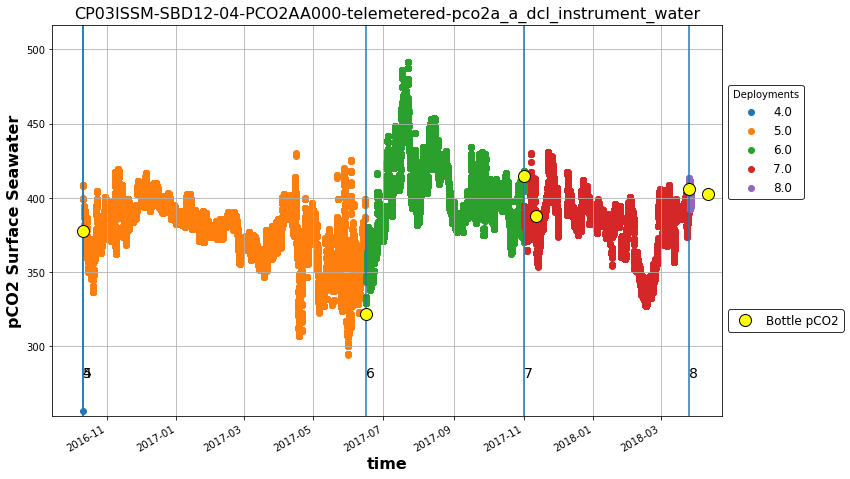

In [96]:
# Plot the selected bottle data against the PHSEN data
fig, ax = plot_variable(pco2a_good, "partial_pressure_co2_ssw")
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(pco2a_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2a_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle pCO2")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)

In the above figure, we can see that deployments 5, 6, and 7 all have discrete bottle data that were collected at deployment and during recovery. For convience, we'll take a look at deployment 6 with the bottle data.

First, select just the PCO2A data associated with deployment 6:

In [97]:
pco2a_dep6 = pco2a.where(pco2a_good.deployment == 6, drop=True)
pco2a_dep6

<xarray.Dataset>
Dimensions:                                   (time: 27513)
Coordinates:
  * time                                      (time) datetime64[ns] 2017-06-1...
Data variables: (12/37)
    air_temperature                           (time) float64 14.25 ... 12.89
    avg_irga_temperature                      (time) float32 40.5 40.5 ... 40.5
    barometric_pressure                       (time) float64 1.019e+03 ... 1....
    current_a2d                               (time) float64 4.297e+04 ... 4....
    date_time_string                          (time) object b'empty' ... b'em...
    dcl_controller_timestamp                  (time) object b'empty' ... b'em...
    ...                                        ...
    sea_surface_temperature                   (time) float64 13.93 ... 16.66
    shortwave_irradiance                      (time) float64 479.7 ... 88.51
    supply_voltage                            (time) float32 nan nan ... nan nan
    zero_a2d                                  (time) float64 4.548e+04 ... 4....
    rollup_annotations_qc_results             (time) float64 0.0 0.0 ... 0.0 0.0
    partial_pressure_co2_ssw_autozero_flag    (time) float64 1.0 1.0 ... 1.0 1.0
Attributes: (12/70)
    node:                               SBD12
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             pco2a_a_dcl_instrument_water
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.35945
    lon:                                -70.88498
    Location_name:                      Coastal Pioneer Inshore Surface Moori...

Find the nearest bottle samples to the start and end of deployment 3:

In [98]:
dt = pd.Timedelta(days=1)
tmin = pd.to_datetime(pco2a_dep6.time.min().values, utc=True) - dt
tmax = pd.to_datetime(pco2a_dep6.time.max().values, utc=True) + dt

pCO2_data = pco2a_bottles.dropna(subset=["Calculated pCO2 [uatm]"])
pCO2_data_dep6 = pCO2_data[(pCO2_data["Start Time [UTC]"] >= tmin) & (pCO2_data["Start Time [UTC]"] <= tmax)]

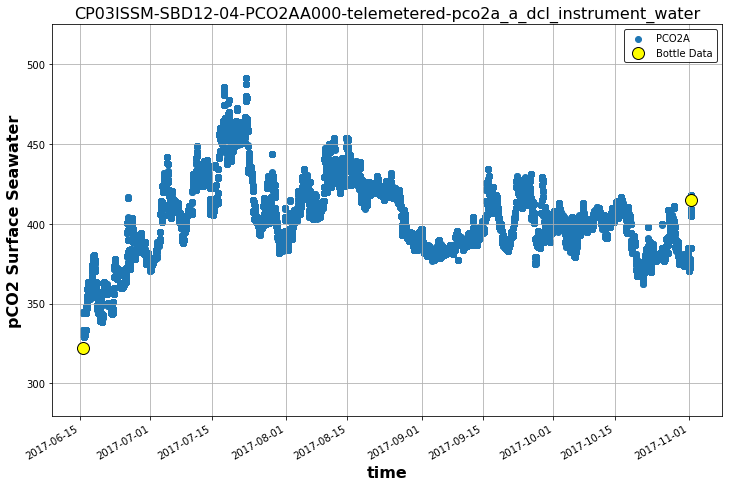

In [99]:
# Plot a comparison of Deployment 3 PHSEN and Bottle data
fig, ax = plot_variable(pco2a_dep6, "partial_pressure_co2_ssw", add_deployments=False)
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

ax.plot(pCO2_data_dep6["Start Time [UTC]"], pCO2_data_dep6["Calculated pCO2 [uatm]"], 
        marker="o", linestyle="", color="yellow", markersize=12, markeredgecolor="black")
ax.legend(["PCO2A", "Bottle Data"], edgecolor="black")


In [100]:
pCO2_data_dep6["Start Time [UTC]"] = pCO2_data_dep6["Start Time [UTC]"].apply(lambda x: x.tz_localize(None))

Next, we can get the pH data which is directly associated with the 

In [101]:
# Get the data to directly compare values
# Find data which is +/- 12-hours of each bottle to normalize over a daily-cycle
dt = pd.Timedelta(hours=1.5)
results = pd.DataFrame(columns=["Time", "Avg", "Std"])
for t in pCO2_data_dep6["Start Time [UTC]"]:
    mask = pco2a_dep6.time[(pco2a_dep6.time <= t + dt) & (pco2a_dep6.time >= t-dt)]
    pCO2_pco2a_avg = pco2a_dep6["partial_pressure_co2_ssw"][(pco2a_dep6["time"] >= t-dt) & (pco2a_dep6["time"] <= t + dt)].mean().values
    pCO2_pco2a_std = pco2a_dep6["partial_pressure_co2_ssw"][(pco2a_dep6["time"] >= t-dt) & (pco2a_dep6["time"] <= t + dt)].std().values
    results = results.append({
        "Time": t,
        "Avg": pCO2_pco2a_avg,
        "Std": pCO2_pco2a_std
    }, ignore_index=True)

Plot the comparison of the bottle data against the PHSEN data:

Text(0, 0.5, 'Sensor pCO2')

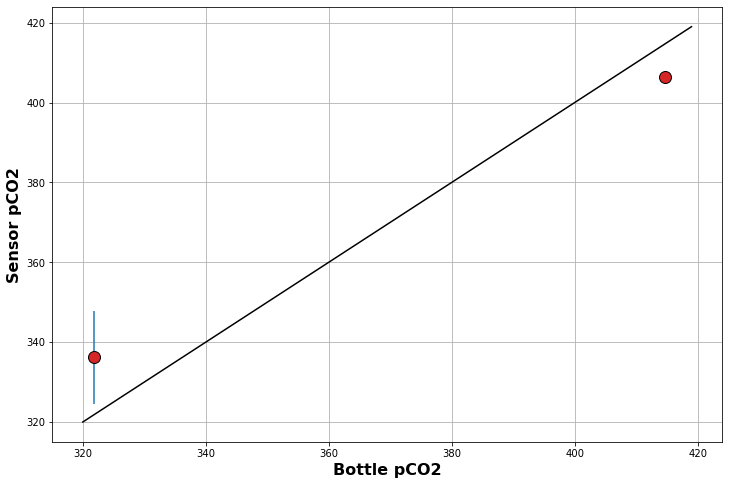

In [102]:
fig, ax = plt.subplots(figsize=(12, 8))

line = np.arange(320, 420, 1)
ax.vlines(pCO2_data_dep6["Calculated pCO2 [uatm]"], results["Avg"]-results["Std"]*2, results["Avg"]+results["Std"]*2)
ax.plot(pCO2_data_dep6["Calculated pCO2 [uatm]"], results["Avg"], marker="o", linestyle="", color="tab:red", markeredgecolor="black", markersize=12)
s, = ax.plot(line, line, color="black")
ax.grid()
ax.set_xlabel("Bottle pCO2", fontsize=16, fontweight="bold")
ax.set_ylabel("Sensor pCO2", fontsize=16, fontweight="bold")

The above figure shows that, within the variability of the ```PHSEN```, the instrument measures the correct pH in the water as determined by laboratory analysis at the beginning and end of the instrument's deployment. 

If we want, we can try to correct the time series data for the differences at the beginning and end of the deployment. However, for the Sunburst SAMI-pH sensor, this is not considered best practice because the relative measurement made by the instrument is supposed to be self-correcting and thus immune to drift.

In [104]:
# Calculate the difference between the sensor and bottle pH
pCO2_data_dep6["delta pCO2"] = results["Avg"].values - pCO2_data_dep6["Calculated pCO2 [uatm]"].values
pCO2_data_dep6["delta pCO2"]

135     -8.313559
1304    14.364027
Name: delta pCO2, dtype: object

In [105]:
pCO2_data_dep6["CTD Bottle Closure Time [UTC]"]

135    2017-11-01 13:00:05+00:00
1304   2017-06-15 14:50:22+00:00
Name: CTD Bottle Closure Time [UTC], dtype: datetime64[ns, UTC]

In [106]:
# Calculate the time difference in seconds
np.datetime64("2017-11-01 13:00:05+00:00") - np.datetime64("2017-06-15 14:50:22+00:00")

numpy.timedelta64(12002983,'s')

In [108]:
# Calculate the fit using linear algrebra (this is so we don't have to install extra packages like either statsmodel
# or )
pCO2_data_dep6[["CTD Bottle Closure Time [UTC]","delta pCO2"]]

,CTD Bottle Closure Time [UTC],delta pCO2
135,2017-11-01 13:00:05+00:00,-8.313559
1304,2017-06-15 14:50:22+00:00,14.364027


Calculate the drift correction for the pH data based on the $\Delta$pH between the sensor and the bottle data, and using linear algrebra: <br>

<p align="center">
    $y = \beta*X$ -> $\beta = (X^{T}X)^{-1}X^{T}y$
</p>

In [109]:
X = np.matrix([[1, 0],[1, 12002983]])

XT = np.matrix.transpose(X)

y = np.matrix([[14.364027], 
               [-8.313559]])

XT_X = np.matmul(XT, X)


XT_y = np.matmul(XT, y)


betas = np.matmul(np.linalg.inv(XT_X), XT_y)
intercept, slope = float(betas[0]), float(betas[1])
print(intercept)
print(slope)

14.364026999999997
-1.8893291775886042e-06


Now calculate the correction as sensor pH + (delta pH * slope * delta time + intercept) 

In [110]:
dT = ((pco2a_dep6["time"] - pco2a_dep6["time"][0])/1E9).astype(int)
correction = intercept + slope*dT
pco2a_dep6["partial_pressure_co2_ssw_corrected"] = pco2a_dep6["partial_pressure_co2_ssw"] + correction

Plot the comparison

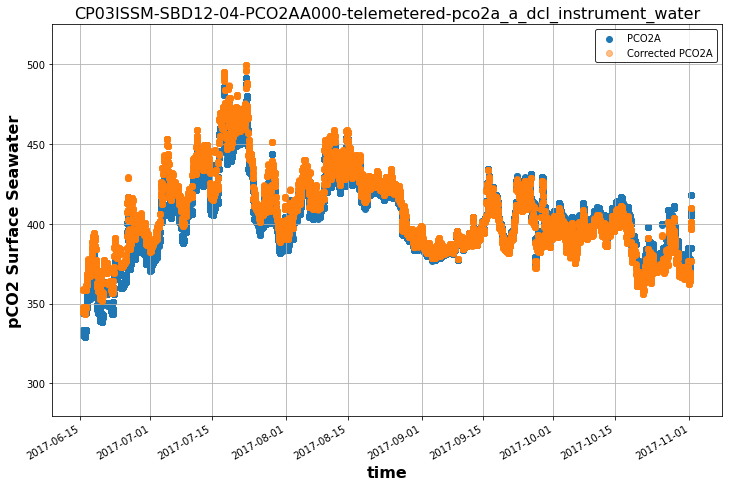

In [111]:
fig, ax = plot_variable(pco2a_dep6, "partial_pressure_co2_ssw", add_deployments=False)
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

ax.plot(pco2a_dep6["time"], pco2a_dep6["partial_pressure_co2_ssw_corrected"], 
        marker="o", linestyle="", color="tab:orange", alpha=0.5)
ax.legend(["PCO2A", "Corrected PCO2A"], edgecolor="black")